# Steering Vectors
- Find and evalulate candidate steering vectors for inverse/surface scope in doubly quantified sentences

## Load Model

In [67]:
import torch
from transformer_lens import HookedTransformer
from transformers import AutoTokenizer, AutoModelForCausalLM

MODEL_NAME = "Qwen/Qwen2.5-1.5B"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.bfloat16 if (DEVICE == "cuda") else torch.float32

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

model = HookedTransformer.from_pretrained(
    model_name=MODEL_NAME,
    device=DEVICE,
    dtype=DTYPE,
    tokenizer=tokenizer
)
model.eval()

Loaded pretrained model Qwen/Qwen2.5-1.5B into HookedTransformer


HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (blocks): ModuleList(
    (0-27): 28 x TransformerBlock(
      (ln1): RMSNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): RMSNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): GroupedQueryAttention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
        (hook_rot_k): HookPoint()
        (hook_rot_q): HookPoint()
      )
      (mlp): GatedMLP(
        (hook_pre): HookPoint()
        (hook_pre_linear): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_att

## Extract $h_i$

In [68]:
target_aggregation_token = {
    "zh_period": 1773,
    "en_period": 13,
}

In [69]:
print("Sanity check tokenization")
# text = "A shark ate every pirate."
text = "有一个厨师吃了每个政治家。有很多个厨师。"
# text = "有一个厨师吃了每个政治家。"
# text = "A shark ate every pirate. There was only one shark."
tokens = model.to_tokens(text)  # [batch, seq]

print("original text: ", text)
print(model.to_str_tokens(text))
for i, token in enumerate(tokens.squeeze()):
    print(i, token.item(), tokenizer.decode(token.item()))

Sanity check tokenization
original text:  有一个厨师吃了每个政治家。有很多个厨师。
['有一个', '厨师', '吃了', '每个', '政治', '家', '。', '有很多', '个', '厨师', '。']
0 104133 有一个
1 114396 厨师
2 105705 吃了
3 103991 每个
4 101091 政治
5 45629 家
6 1773 。
7 101194 有很多
8 18947 个
9 114396 厨师
10 1773 。


In [70]:
# TODO batch this
def get_hidden(
    model: HookedTransformer,
    # tokens: torch.Tensor,
    text: str,
    target_token_id: int,
) -> torch.Tensor:
    
    tokens = model.to_tokens(text)  # [batch, seq]
    target_idx = [token.item() for token in tokens.squeeze()].index(target_token_id)

    logits, cache = model.run_with_cache(tokens)
    n_layers = model.cfg.n_layers

    resid_pre  = [cache[f"blocks.{l}.hook_resid_pre"]  for l in range(n_layers)]
    resid_pre  = torch.stack(resid_pre,  dim=0)

    hidden = resid_pre[:, :, target_idx, :].squeeze(1) # [layer, d_model]

    return hidden

In [71]:
import pandas as pd
import numpy as np

In [72]:
def get_mu_hidden(df: pd.DataFrame, language: str, scope: str, target_token_id: int) -> torch.Tensor:
    """
    Returns the average activation for a 
    """
    activations = []
    for sentence in df[df["language"] == language][df["preference_mean"] == scope]["sentence"]:
        activations.append(get_hidden(model, sentence, target_token_id))

    return torch.stack(activations).mean(dim=0)

In [73]:
EN_PERIOD_ID = 13
ZH_PERIOD_ID = 1773

def get_boundary_id(lang: str) -> int:
    return EN_PERIOD_ID if lang == "en" else ZH_PERIOD_ID

def prompt_period_index(model, prompt: str, boundary_id: int) -> int:
    ids = model.to_tokens(prompt, prepend_bos=False).squeeze(0)
    return list(ids).index(boundary_id)

In [74]:
df_ue = pd.read_json("results/qwen2.5/tokenize_no_space_1.5b/scored_wide_ue_Qwen_Qwen2.5-1.5B-2.jsonl", lines=True)
df_eu = pd.read_json("results/qwen2.5/tokenize_no_space_1.5b/scored_wide_eu_Qwen_Qwen2.5-1.5B-2.jsonl", lines=True)

# align column order
df_eu = df_eu[df_ue.columns]

df = pd.concat([df_ue, df_eu], ignore_index=True)

# IMPORTANT: align rows with activations
df = df.reset_index(drop=True)
df["t_prompt_period"] = df.apply(
    lambda r: prompt_period_index(
        model,
        r["sentence"],
        get_boundary_id(r["language"]),
    ),
    axis=1,
)
df

,model,stimulus_id,concept_id,language,template_id,subj,obj,verb,sentence,tid,...,continuation_text_surface,full_text_inverse,full_text_surface,delta_sum,ratio_sum,delta_mean,ratio_mean,preference_sum,preference_mean,t_prompt_period
0,Qwen_Qwen2.5-1.5B,en-t0_s0_o0_v0,shark|pirate|ate,en,en_0,shark,pirate,ate,Every shark ate a pirate.,0,...,There was only one pirate.,Every shark ate a pirate. There were many pira...,Every shark ate a pirate. There was only one p...,1.534791,4.640356,-0.157645,0.854153,inverse,surface,5
1,Qwen_Qwen2.5-1.5B,en-t0_s0_o0_v1,shark|pirate|helped,en,en_0,shark,pirate,helped,Every shark helped a pirate.,0,...,There was only one pirate.,Every shark helped a pirate. There were many p...,Every shark helped a pirate. There was only on...,1.788671,5.981495,-0.079300,0.923763,inverse,surface,5
2,Qwen_Qwen2.5-1.5B,en-t0_s0_o0_v2,shark|pirate|pushed,en,en_0,shark,pirate,pushed,Every shark pushed a pirate.,0,...,There was only one pirate.,Every shark pushed a pirate. There were many p...,Every shark pushed a pirate. There was only on...,1.597416,4.940250,-0.122437,0.884762,inverse,surface,5
3,Qwen_Qwen2.5-1.5B,en-t0_s0_o0_v3,shark|pirate|chased,en,en_0,shark,pirate,chased,Every shark chased a pirate.,0,...,There was only one pirate.,Every shark chased a pirate. There were many p...,Every shark chased a pirate. There was only on...,-0.460211,0.631151,-0.496891,0.608419,surface,surface,5
4,Qwen_Qwen2.5-1.5B,en-t0_s0_o1_v0,shark|student|ate,en,en_0,shark,student,ate,Every shark ate a student.,0,...,There was only one student.,Every shark ate a student. There were many stu...,Every shark ate a student. There was only one ...,2.499035,12.170742,0.010185,1.010237,inverse,inverse,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,Qwen_Qwen2.5-1.5B,zh-t0_s4_o3_v3,袋鼠|游客|追,zh,zh_0,袋鼠,游客,追,有一只袋鼠追了每个游客。,0,...,只有一只袋鼠。,有一只袋鼠追了每个游客。有很多只袋鼠。,有一只袋鼠追了每个游客。只有一只袋鼠。,-3.090139,0.045496,-1.032434,0.356139,surface,surface,8
396,Qwen_Qwen2.5-1.5B,zh-t0_s4_o4_v0,袋鼠|政治家|吃,zh,zh_0,袋鼠,政治家,吃,有一只袋鼠吃了每个政治家。,0,...,只有一只袋鼠。,有一只袋鼠吃了每个政治家。有很多只袋鼠。,有一只袋鼠吃了每个政治家。只有一只袋鼠。,-3.274755,0.037826,-1.058013,0.347145,surface,surface,8
397,Qwen_Qwen2.5-1.5B,zh-t0_s4_o4_v1,袋鼠|政治家|帮助,zh,zh_0,袋鼠,政治家,帮助,有一只袋鼠帮助了每个政治家。,0,...,只有一只袋鼠。,有一只袋鼠帮助了每个政治家。有很多只袋鼠。,有一只袋鼠帮助了每个政治家。只有一只袋鼠。,-3.142306,0.043183,-1.083221,0.338503,surface,surface,9
398,Qwen_Qwen2.5-1.5B,zh-t0_s4_o4_v2,袋鼠|政治家|推,zh,zh_0,袋鼠,政治家,推,有一只袋鼠推了每个政治家。,0,...,只有一只袋鼠。,有一只袋鼠推了每个政治家。有很多只袋鼠。,有一只袋鼠推了每个政治家。只有一只袋鼠。,-3.239157,0.039197,-1.052541,0.349050,surface,surface,9


In [75]:
@torch.no_grad()
def extract_H_one_layer(
    model,
    df: pd.DataFrame,
    *,
    layer: int,
    hook_point: str = "resid_pre",
    batch_size: int = 16,
) -> torch.Tensor:
    """
    Returns H: [N, d_model] for the specified layer.
    """
    prompts = df["sentence"].tolist()
    t_pos = torch.tensor(df["t_prompt_period"].tolist(), dtype=torch.long)

    outs = []

    for start in range(0, len(prompts), batch_size):
        end = min(len(prompts), start + batch_size)

        p_batch = prompts[start:end]
        t_batch = t_pos[start:end]

        toks = model.to_tokens(p_batch)
        hook = f"blocks.{layer}.hook_{hook_point}"

        _, cache = model.run_with_cache(toks, names_filter=[hook])

        acts = cache[hook]              # [B, T, d_model]
        B = acts.shape[0]
        b_idx = torch.arange(B, device=acts.device)

        H_batch = acts[b_idx, t_batch.to(acts.device)]
        outs.append(H_batch.detach().cpu())

    return torch.cat(outs, dim=0)       # [B, d_model]

In [76]:
def get_mu_from_H(
    H: torch.Tensor,      # [B, d_model]
    df: pd.DataFrame,
    *,
    language: str,
    scope: str,           # "surface" | "inverse"
) -> torch.Tensor:
    mask = (
        (df["language"] == language) &
        (df["preference_mean"] == scope)
    ).to_numpy()

    if  np.all(mask == False):
        _, d_model = H.shape
        return torch.zeros(d_model)
    return H[mask].mean(dim=0)

In [77]:
def fit_v_hat(H_train, df_train, *, language: str):
    mu_surface = get_mu_from_H(H_train, df_train, language=language, scope="surface")
    mu_inverse = get_mu_from_H(H_train, df_train, language=language, scope="inverse")
    v = mu_inverse - mu_surface
    return v / (v.norm() + 1e-8)

In [78]:
import numpy as np
from sklearn.metrics import roc_auc_score

def auc_on_test(H_test, df_test, v_hat, *, language: str):
    mask = (df_test["language"] == language).to_numpy()
    H = H_test[mask]
    y = (df_test[mask]["preference_mean"] == "inverse").astype(int).to_numpy()
    if y.min() == y.max():   # only one class
        return float("nan")
    p = (H @ v_hat.cpu()).numpy()
    return float(roc_auc_score(y, p))

In [79]:
def sweep_layers_auc(model, df_train, df_test, *, language: str, hook_point="resid_pre", batch_size=16):
    aucs = []
    layers = list(range(model.cfg.n_layers))
    for l in layers:
        H_tr = extract_H_one_layer(model, df_train, layer=l, hook_point=hook_point, batch_size=batch_size)
        v_hat = fit_v_hat(H_tr, df_train, language=language)

        H_te = extract_H_one_layer(model, df_test, layer=l, hook_point=hook_point, batch_size=batch_size)
        aucs.append(auc_on_test(H_te, df_test, v_hat, language=language))
    return aucs


In [80]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

def plot_separability_hist(
    H,
    df,
    v_hat,
    *,
    language: str,
    title: str,
    save_path: str | None = None,
):
    mask = (df["language"] == language).to_numpy()
    H_lang = H[mask]
    df_lang = df[mask]

    p = (H_lang @ v_hat.cpu()).numpy()
    y = df_lang["preference_mean"].to_numpy()

    p_surf = p[y == "surface"]
    p_inv  = p[y == "inverse"]

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.hist(p_surf, bins=40, alpha=0.6, label="surface")
    ax.hist(p_inv,  bins=40, alpha=0.6, label="inverse")

    ax.set_title(title)
    ax.set_xlabel("p = vᵀh")
    ax.set_ylabel("count")
    ax.legend()

    if save_path is not None:
        fig.savefig(save_path, bbox_inches="tight")

    plt.close(fig)


In [81]:
from sklearn.model_selection import train_test_split

df = df.reset_index(drop=True).copy()

# Combined stratification key
df["strat_key"] = df["language"].astype(str) + "__" + df["preference_mean"].astype(str)

df_train, df_test = train_test_split(
    df,
    test_size=0.3,
    random_state=0,
    stratify=df["strat_key"],
)

df_train = df_train.reset_index(drop=True)
df_test  = df_test.reset_index(drop=True)

print("train counts:\n", df_train.groupby(["language","preference_mean"]).size())
print("test counts:\n",  df_test.groupby(["language","preference_mean"]).size())

train counts:
 language  preference_mean
en        inverse             16
          surface            124
zh        inverse             45
          surface             95
dtype: int64
test counts:
 language  preference_mean
en        inverse             7
          surface            53
zh        inverse            19
          surface            41
dtype: int64


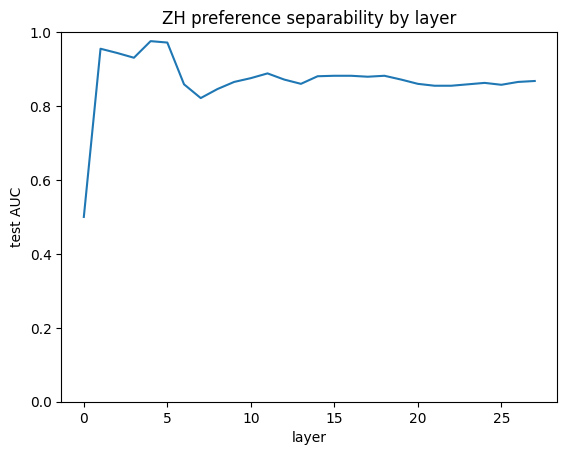

In [85]:
import matplotlib.pyplot as plt
aucs_zh = sweep_layers_auc(model, df_train, df_test, language="zh")
plt.figure()
plt.plot(range(len(aucs_zh)), aucs_zh)
plt.ylim(0.0, 1.0)
plt.xlabel("layer")
plt.ylabel("test AUC")
plt.title("ZH preference separability by layer")
plt.show()

In [86]:
aucs_zh

[0.5,
 0.9550706033376123,
 0.9435173299101411,
 0.9306803594351734,
 0.975609756097561,
 0.9717586649550707,
 0.858793324775353,
 0.8215661103979461,
 0.8459563543003852,
 0.865211810012837,
 0.8754813863928114,
 0.8883183568677793,
 0.871630295250321,
 0.8600770218228498,
 0.8806161745827985,
 0.8818998716302953,
 0.8818998716302953,
 0.8793324775353016,
 0.8818998716302953,
 0.8716302952503209,
 0.8600770218228498,
 0.8549422336328627,
 0.8549422336328627,
 0.858793324775353,
 0.8626444159178434,
 0.8575096277278562,
 0.865211810012837,
 0.8677792041078305]

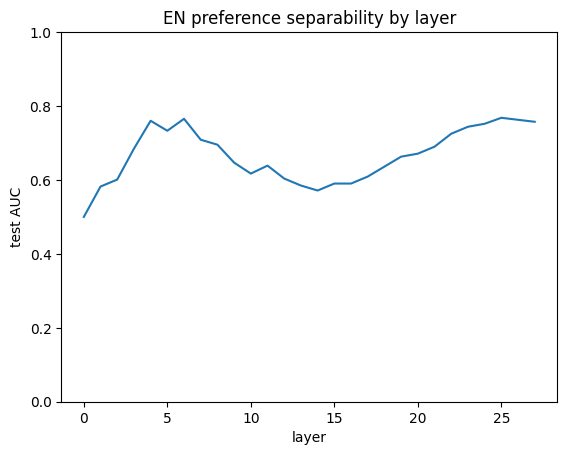

In [83]:
import matplotlib.pyplot as plt

aucs_en = sweep_layers_auc(model, df_train, df_test, language="en")
plt.figure()
plt.plot(range(len(aucs_en)), aucs_en)
plt.ylim(0.0, 1.0)
plt.xlabel("layer")
plt.ylabel("test AUC")
plt.title("EN preference separability by layer")
plt.show()

In [84]:
save_root = Path(f"results/plots/{MODEL_NAME}/test_eu_ue")
save_root_en = save_root / "en"
save_root_zh = save_root / "zh"
save_root_en.mkdir(parents=True, exist_ok=True)
save_root_zh.mkdir(parents=True, exist_ok=True)

n_layers = model.cfg.n_layers
for layer in range(n_layers):
# for layer in [10, 11]:
    print("Extracting layer ", layer)
    H = extract_H_one_layer(model, df_test, layer=layer)
    v_en = fit_v_hat(H, df_test, language="en")
    v_zh = fit_v_hat(H, df_test, language="zh")

    # sanity check
    print("||v_en|| =", v_en.norm().item(), "||v_zh|| =", v_zh.norm().item())

    print("cross-linguistic alignment", torch.dot(v_en, v_zh))
    plot_separability_hist(H, df_test, v_en, language="en", title=f"Layer {layer}: v_en separation for EN data", save_path=save_root_en / f"layer_{layer:02d}_en_hist.png")
    plot_separability_hist(H, df_test, v_zh, language="zh", title=f"Layer {layer}: v_zh separation for ZH data", save_path=save_root_zh / f"layer_{layer:02d}_zh_hist.png")

Extracting layer  0
||v_en|| = 0.0 ||v_zh|| = 0.0
cross-linguistic alignment tensor(0.)
Extracting layer  1
||v_en|| = 1.0 ||v_zh|| = 1.0000001192092896
cross-linguistic alignment tensor(-0.0975)
Extracting layer  2
||v_en|| = 0.9999999403953552 ||v_zh|| = 1.0
cross-linguistic alignment tensor(-0.1234)
Extracting layer  3
||v_en|| = 1.0000001192092896 ||v_zh|| = 0.9999998807907104
cross-linguistic alignment tensor(-0.2797)
Extracting layer  4
||v_en|| = 0.9999998807907104 ||v_zh|| = 1.0000001192092896
cross-linguistic alignment tensor(-0.2675)
Extracting layer  5
||v_en|| = 1.0 ||v_zh|| = 1.0
cross-linguistic alignment tensor(-0.1981)
Extracting layer  6
||v_en|| = 0.9999998211860657 ||v_zh|| = 1.0
cross-linguistic alignment tensor(-0.1900)
Extracting layer  7
||v_en|| = 1.0000001192092896 ||v_zh|| = 1.0
cross-linguistic alignment tensor(-0.1505)
Extracting layer  8
||v_en|| = 0.9999999403953552 ||v_zh|| = 1.0
cross-linguistic alignment tensor(-0.1430)
Extracting layer  9
||v_en|| = 1.

## Intervene with Steering Vector

## 

## 